# Disp visualisation

In [1]:
import sys
sys.path.insert(0, '..')

from lstio.containers import DL1ParametersContainer
from reco.utils import get_event_pos_in_camera
from reco.utils import calc_disp
from reco.utils import cal_cam_source_pos

from ctapipe.utils import get_dataset_path
from ctapipe.io import HDF5TableWriter, HDF5TableReader
from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean
from ctapipe.io import event_source
from ctapipe.image import hillas_parameters
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt

from ctapipe.coordinates import HorizonFrame
from ctapipe.coordinates import NominalFrame

import astropy.units as u

In [2]:
infile = get_dataset_path('gamma_test_large.simtel.gz')   

dl1_parameters_filename = 'dl1.h5'

allowed_tels = {1} # select LST1 only
max_events = 300 # limit the number of events to analyse in files - None if no limit

cal = CameraCalibrator(r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')

cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 4,
                       'picture_thresh': 7,
                       'min_number_picture_neighbors': 3}

dl1_container = DL1ParametersContainer() 

source = event_source(infile, max_events=3)

### Computation and visulisation of the disp for bright events
For each events, the visusalisation shows side by side the true position of the source (red dot), the Hillas ellipse and the disp as the semi-length of the blue segment for:
- the custom code on the left
- the code using ctapipe coordinates transform on the right

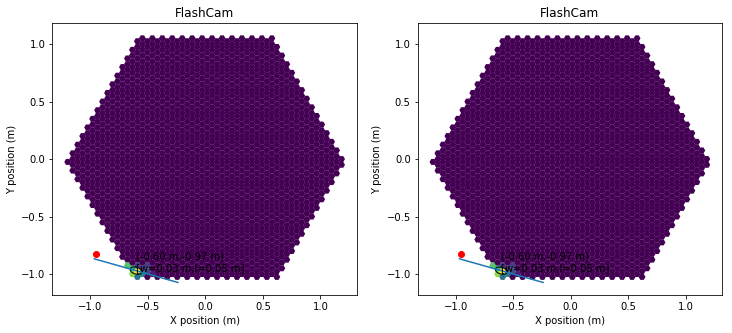

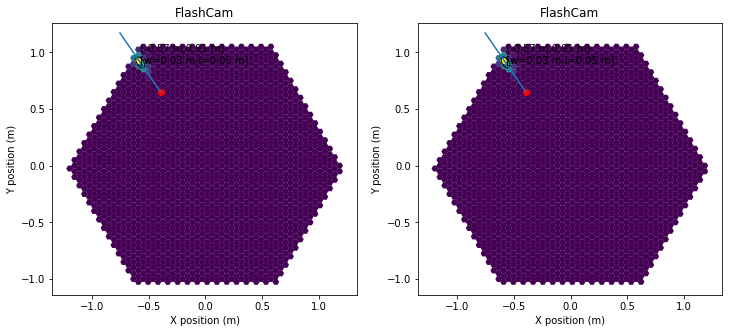

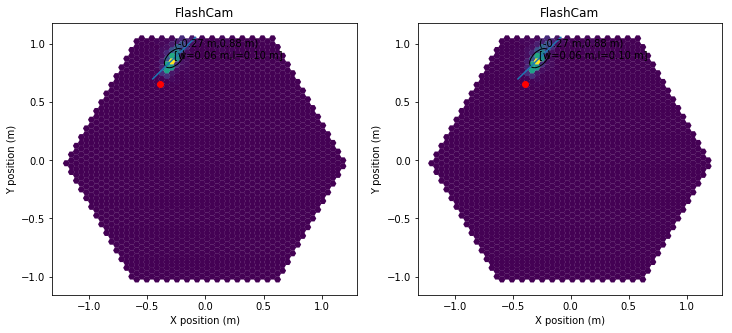

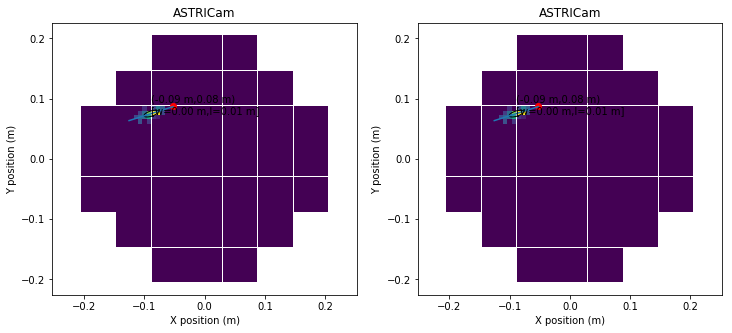

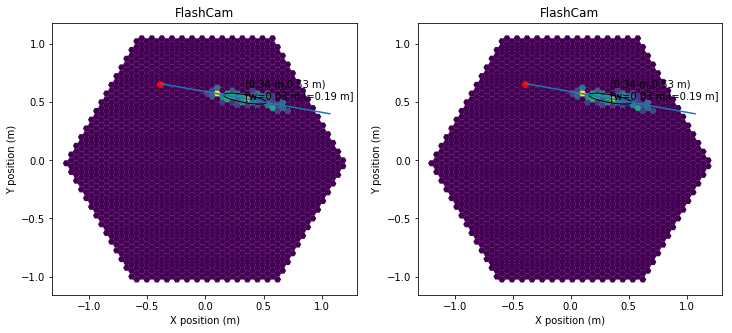

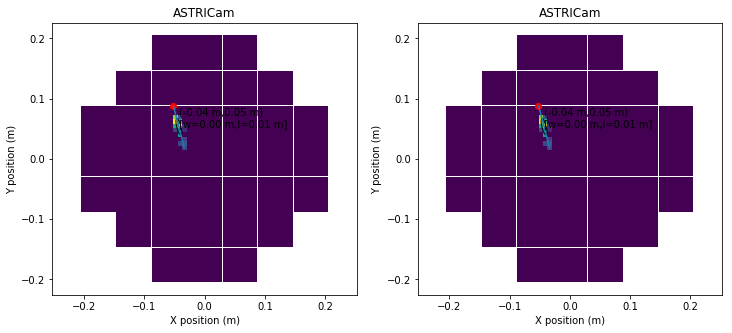

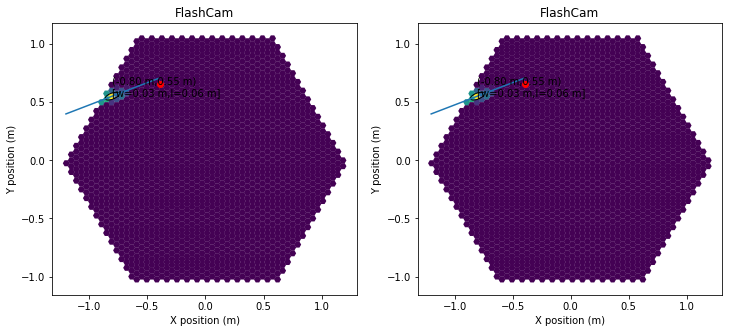

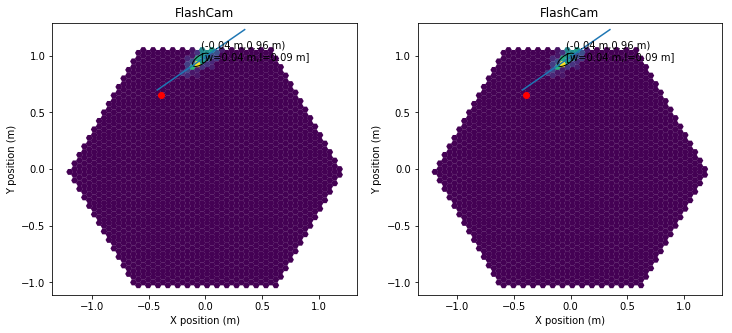

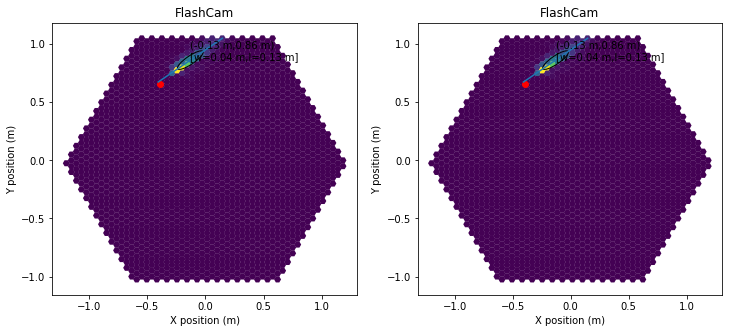

In [4]:
for event in source:
    cal.calibrate(event)

    for telescope_id, dl1 in event.dl1.tel.items():
        tel = event.inst.subarray.tels[telescope_id]
        camera = tel.camera
        signal_pixels = cleaning_method(camera, dl1.image[0], 
                              **cleaning_parameters)

        image = dl1.image[0]
        image[~signal_pixels] = 0

        if image.sum() > 300:
            try:
                hillas = hillas_parameters(
                    camera,
                    image
                )
            except:
                print("bad cleaning?")
                pass

    ## Fill container ##
            dl1_container.fill_mc(event)
            dl1_container.fill_hillas(hillas)
            dl1_container.fill_event_info(event)
            dl1_container.set_mc_core_distance(event, telescope_id)
            dl1_container.set_source_camera_position(event, telescope_id)
            dl1_container.set_disp([dl1_container.src_x, dl1_container.src_y], hillas)
            disp_v2 = dl1_container.disp

        
            fig, axes = plt.subplots(1,2, figsize=(12,5))
        
            ## version 1 ##

            src_x, src_y = cal_cam_source_pos(event.mc.alt.value, 
                               event.mc.az.value, 
                               event.mcheader.run_array_direction[1].value,
                               event.mcheader.run_array_direction[0].value,
                               tel.optics.equivalent_focal_length.value,
                              )
            disp_v1 = calc_disp(src_x, src_y, hillas.x.value, hillas.y.value)
            
            display = CameraDisplay(camera, image, ax=axes[0])
            display.overlay_moments(hillas)
            axes[0].scatter(src_x, src_y, color='red')
            x = np.linspace(-disp_v1, disp_v1, 2)
            axes[0].plot(hillas.x * np.ones(2) + x*np.cos(hillas.psi)*u.m, 
                     hillas.y * np.ones(2) + x*np.sin(hillas.psi)*u.m)
            
            ## disp version 2 ##
            source_pos = get_event_pos_in_camera(event, tel)

            display = CameraDisplay(camera, image, ax=axes[1])
            display.overlay_moments(hillas)
            axes[1].scatter(source_pos[0], source_pos[1], color='red')
            x = np.linspace(-disp_v2.value, disp_v2.value, 2)
            axes[1].plot(hillas.x * np.ones(2) + x*np.cos(hillas.psi)*u.m, 
                     hillas.y * np.ones(2) + x*np.sin(hillas.psi)*u.m)
            
            plt.show()


## A bit of computnig performances

In [5]:
%%timeit
src_x, src_y = cal_cam_source_pos(event.mc.alt.value, 
                                  event.mc.az.value,
                                  event.mcheader.run_array_direction[1].value,
                                  event.mcheader.run_array_direction[0].value,
                                  tel.optics.equivalent_focal_length.value,
                              )

468 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%%timeit
source_pos = get_event_pos_in_camera(event, tel)


5.59 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The change of frame with astropy coordinates is quite slow.   
It seems that custom code is 10 times faster and gives the same results.   
However it might be more error-prone if camera rotation changes or ctapipe coordinates are handled differently in the future.